# Evaluation Framework: Visualize & Analyze Residuals

We are ready with our baseline model, now its time to investigate the goodness of fit using forecast errors. These errors on time series problems are called residuals or residual errors. Analyzing the residual error of our model can explain a lot about our forecast and even suggest improvements.
Let’s recalculate the residuals of our naive forecast on the same dataset to explore further in this section.

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import autocorrelation_plot
plt.style.use("seaborn-whitegrid")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Test RMSE: 49.409


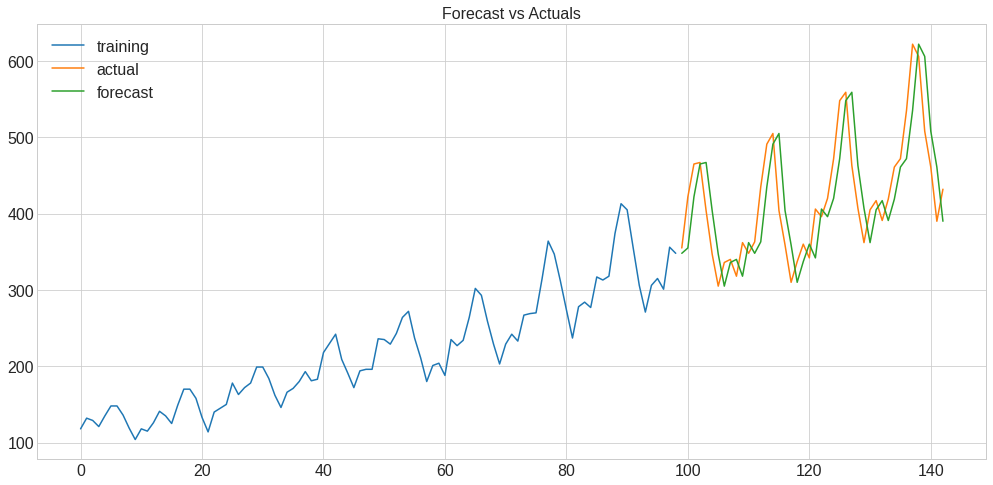

In [2]:
# get example model to analyse

# load data
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
raw_df = pd.read_csv(url, header=0, parse_dates=True)

# create lag feature
df = raw_df.copy().drop(["Month"], axis=1)
df.columns = ["t"]
df["t+1"] = df.shift(-1)


# train test split
train_size = int(df.shape[0] * 0.7)

train = df.iloc[:train_size-1]
test = df.iloc[train_size-1:-1]

train_X = train.loc[:,"t"]
train_y = train.loc[:,"t+1"]

test_X = test.loc[:,"t"]
test_y = test.loc[:,"t+1"]

# create baseline model (Naive model)
def model_persistence(x):
  return x

# walk-forward validation
predicted = list()
for x in test_X:
  yhat = model_persistence(x)
  predicted.append(yhat)
predicted = pd.Series(np.array(predicted))
predicted.index = test_y.index

# Root Mean Squared Error (RMSE)
rmse = np.mean((predicted - test_y)**2)**.5
print("Test RMSE: {:.3f}".format(rmse))

# Plot
plt.figure(figsize=(17,8))

plt.plot(train_y, label='training')
plt.plot(test_y, label='actual')
plt.plot(predicted, label='forecast')

plt.title('Forecast vs Actuals', fontsize=16)
plt.legend(loc='upper left', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

## Residuals of Naive Forecast

In [3]:
# calculate forecast error (residual)
residuals = pd.DataFrame(test_y - predicted)
residuals.columns = ["Residuals"]
residuals.head()

,Residuals
99,7.0
100,67.0
101,43.0
102,2.0
103,-63.0


## Residual Line Plot

The first plot is to look at the residuals over time as a line plot. We would not expect any trend and cyclic behavior if the model is fitted well, the plot should be random around the value of 0.

Here, we can still observe a cyclic behavior in the line plot which suggests a scope of improvement in the model which can be achieved by better feature engineering and exploring other advanced models.

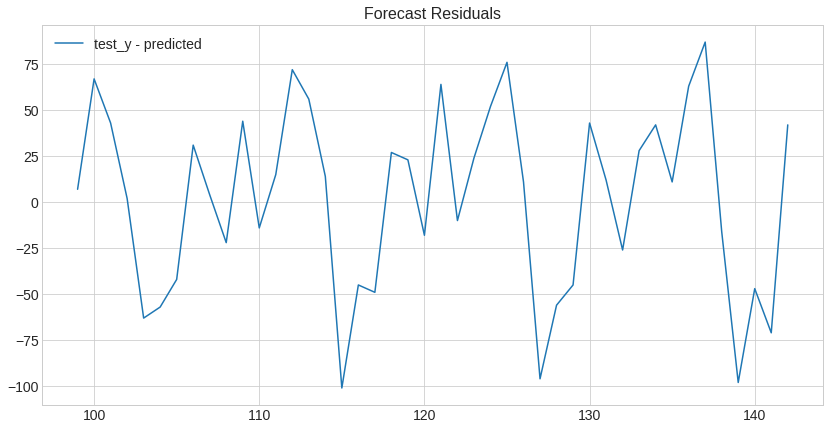

In [4]:
# Plot residuals as line plot
plt.figure(figsize=(14,7))
plt.plot(residuals, label='test_y - predicted')
plt.title('Forecast Residuals', fontsize=16)
plt.legend(loc='upper left', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Residual Summary Statistics

Next, we can analyze summary statistics on the residual errors. Primarily, we are interested in the mean value of the residual errors. A value close to zero suggests no bias in the forecasts, whereas positive and negative values suggest a positive or negative bias in the forecasts.

Here, summary statistics also suggest a positive bias in the model.

In [5]:
# summary statistics
print(residuals.describe())

        Residuals
count   44.000000
mean     1.909091
std     49.943139
min   -101.000000
25%    -42.750000
50%     11.000000
75%     42.250000
max     87.000000


## Residual Histogram & Density Plots

These plots can be used to better understand the distribution of errors beyond summary statistics. We would expect the forecast errors to be normally distributed around a zero mean. Plots can help discover skews in this distribution. We can use both histograms and density plots to better understand the distribution of residual errors.

Here, it can be clearly observed residuals are not distributed normally, they are negatively skewed. Again, this confirms that our model needs improvement.

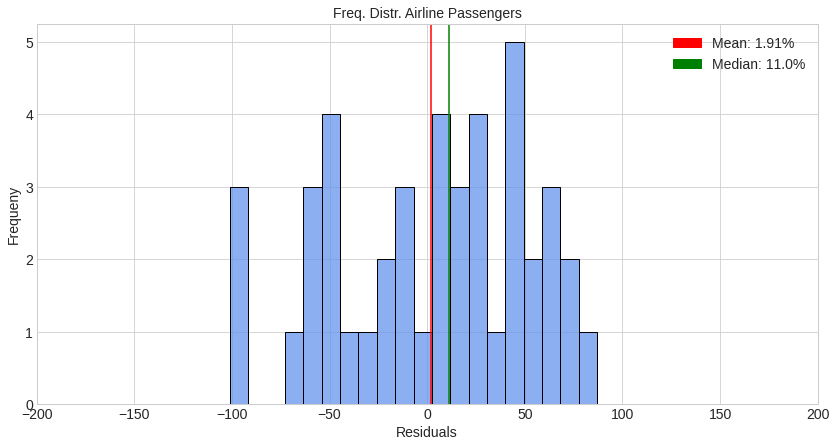

In [6]:
# plot histogram
plt.figure(figsize=(14,7))

sns.histplot(data=residuals, 
             x="Residuals", 
             bins=20,
             color="cornflowerblue",
             line_kws={"linewidth": 2})

mean = residuals["Residuals"].mean()
median = residuals["Residuals"].median()
plt.axvline(x=mean, c="r")
plt.axvline(x=median, c="g")
mean_patch = mpatches.Patch(color="r", label="Mean: {}%".format(np.around(mean,2)))
median_patch = mpatches.Patch(color="g", label="Median: {}%".format(np.around(median,2)))

plt.legend(handles=[mean_patch, median_patch], fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Residuals", fontsize=14)
plt.ylabel("Frequeny", fontsize=14)
plt.title("Freq. Distr. Airline Passengers", fontsize=14)
plt.xlim(-200, 200)

plt.show()

<Figure size 1008x504 with 0 Axes>

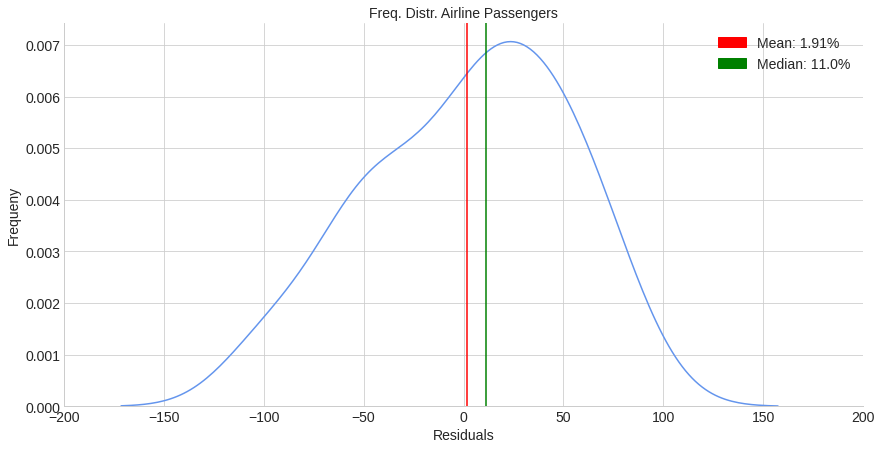

In [7]:
# plot kde
plt.figure(figsize=(14,7))

sns.displot(residuals, 
            x="Residuals", 
            kind="kde", 
            color="cornflowerblue",
            height=6,
            aspect=12/6)

mean = residuals["Residuals"].mean()
median = residuals["Residuals"].median()
plt.axvline(x=mean, c="r")
plt.axvline(x=median, c="g")
mean_patch = mpatches.Patch(color="r", label="Mean: {}%".format(np.around(mean,2)))
median_patch = mpatches.Patch(color="g", label="Median: {}%".format(np.around(median,2)))

plt.legend(handles=[mean_patch, median_patch], fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Residuals", fontsize=14)
plt.ylabel("Frequeny", fontsize=14)
plt.title("Freq. Distr. Airline Passengers", fontsize=14)
plt.xlim(-200, 200)

plt.show()

## Residual Q-Q Plot

This is also called a quantile plot, can be used to check the normality of the distribution of residuals. The values are ordered and compared to an idealized Gaussian distribution on a scatter plot. We expect all the dots to overlap the diagonal line to confirm a complete match between the two distributions.

We can see some bumps and outliers on the Q-Q plot which need to be corrected in order to achieve a better forecast.

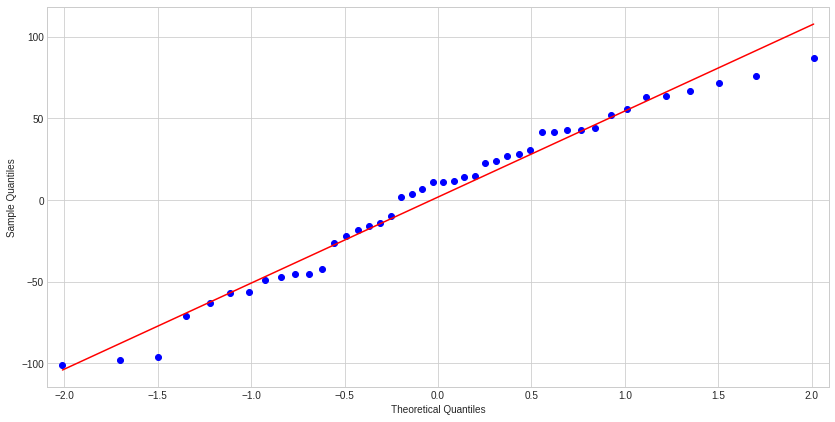

In [8]:
# Draw Q-Q plot
fig, axis = plt.subplots(1,1, figsize=(14,7))
qqplot(np.array(residuals["Residuals"]), line="r", ax=axis)
plt.show()

## Residual Autocorrelation Plot

Autocorrelation explains the strength of the relationship between observation and observations at prior time steps. We would not expect there to be any correlation left between the residuals. Let’s calculate and plot the autocorrelation of the residual errors.

We can see autocorrelation still exists in the residuals which validate our finding that model require improvement in terms of feature engineering and choice of algorithms.

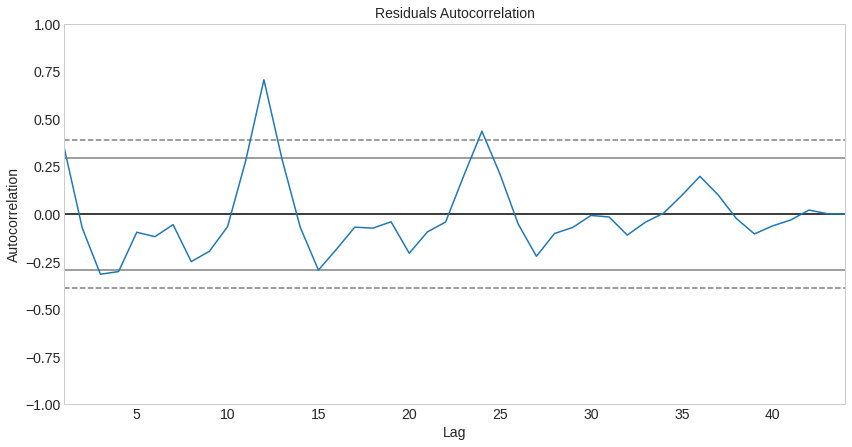

In [9]:
# plot autocorrelation
plt.figure(figsize=(14,7))
autocorrelation_plot(residuals)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Lag", fontsize=14)
plt.ylabel("Autocorrelation", fontsize=14)
plt.title("Residuals Autocorrelation", fontsize=14)
plt.show()